In [5]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #visualisation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from implementations import *
from helpers_perso import *
from plots import *
from proj1_helpers import *
from zipfile import ZipFile

## Loading the data

In [7]:
# Train set
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
with ZipFile('../data/train.csv.zip', 'r') as zip:
    zip.extractall('../data')
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print("Size of the training set: {}.".format(tX.shape[0]))
# Test set
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
with ZipFile('../data/test.csv.zip', 'r') as zip:
    zip.extractall('../data')
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print("Size of the test set: {}.".format(tX_test.shape[0]))

Size of the training set: 250000.
Size of the test set: 568238.


## Exploring the data

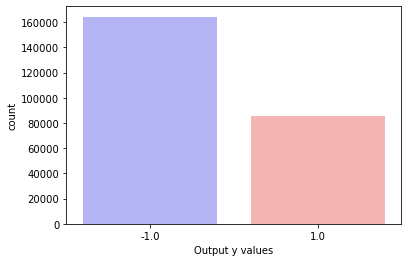

In [8]:
#Exploring y
sns.countplot(x = y, palette = "bwr") 
plt.xlabel("Output y values")
plt.show()

The prediction values are -1 and 1. As our code implementation (specially the loss for the regression) is for 0 and 1 we change these.

In [9]:
# Binary problem change the labels in y 
print("Example", y[0:10])
y = np.where(y == -1, 0, y)
print("Example after", y[0:10])

Example [ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.]
Example after [1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]


In [10]:
tX.shape[1]

30

There are 30 features

In [11]:
tX[0:3]

array([[ 1.38470e+02,  5.16550e+01,  9.78270e+01,  2.79800e+01,
         9.10000e-01,  1.24711e+02,  2.66600e+00,  3.06400e+00,
         4.19280e+01,  1.97760e+02,  1.58200e+00,  1.39600e+00,
         2.00000e-01,  3.26380e+01,  1.01700e+00,  3.81000e-01,
         5.16260e+01,  2.27300e+00, -2.41400e+00,  1.68240e+01,
        -2.77000e-01,  2.58733e+02,  2.00000e+00,  6.74350e+01,
         2.15000e+00,  4.44000e-01,  4.60620e+01,  1.24000e+00,
        -2.47500e+00,  1.13497e+02],
       [ 1.60937e+02,  6.87680e+01,  1.03235e+02,  4.81460e+01,
        -9.99000e+02, -9.99000e+02, -9.99000e+02,  3.47300e+00,
         2.07800e+00,  1.25157e+02,  8.79000e-01,  1.41400e+00,
        -9.99000e+02,  4.20140e+01,  2.03900e+00, -3.01100e+00,
         3.69180e+01,  5.01000e-01,  1.03000e-01,  4.47040e+01,
        -1.91600e+00,  1.64546e+02,  1.00000e+00,  4.62260e+01,
         7.25000e-01,  1.15800e+00, -9.99000e+02, -9.99000e+02,
        -9.99000e+02,  4.62260e+01],
       [-9.99000e+02,  1.62172

A quick look in the data reveils there a many -999 values. The datasheet tells us that these are invalid values. 

Set them to NaN

In [12]:
for t_set in [tX, tX_test]:
    t_set[t_set == -999] = np.nan

In [13]:
tX[3]

array([ 1.43905e+02,  8.14170e+01,  8.09430e+01,  4.14000e-01,
                nan,          nan,          nan,  3.31000e+00,
        4.14000e-01,  7.59680e+01,  2.35400e+00, -1.28500e+00,
                nan,  2.26470e+01, -1.65500e+00,  1.00000e-02,
        5.33210e+01, -5.22000e-01, -3.10000e+00,  3.10820e+01,
        6.00000e-02,  8.60620e+01,  0.00000e+00,          nan,
                nan,          nan,          nan,          nan,
                nan,  0.00000e+00])

We successfully replaced all the invalid data.

### Visualisation of the data: checking the distribution

C:\Users\maxen\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


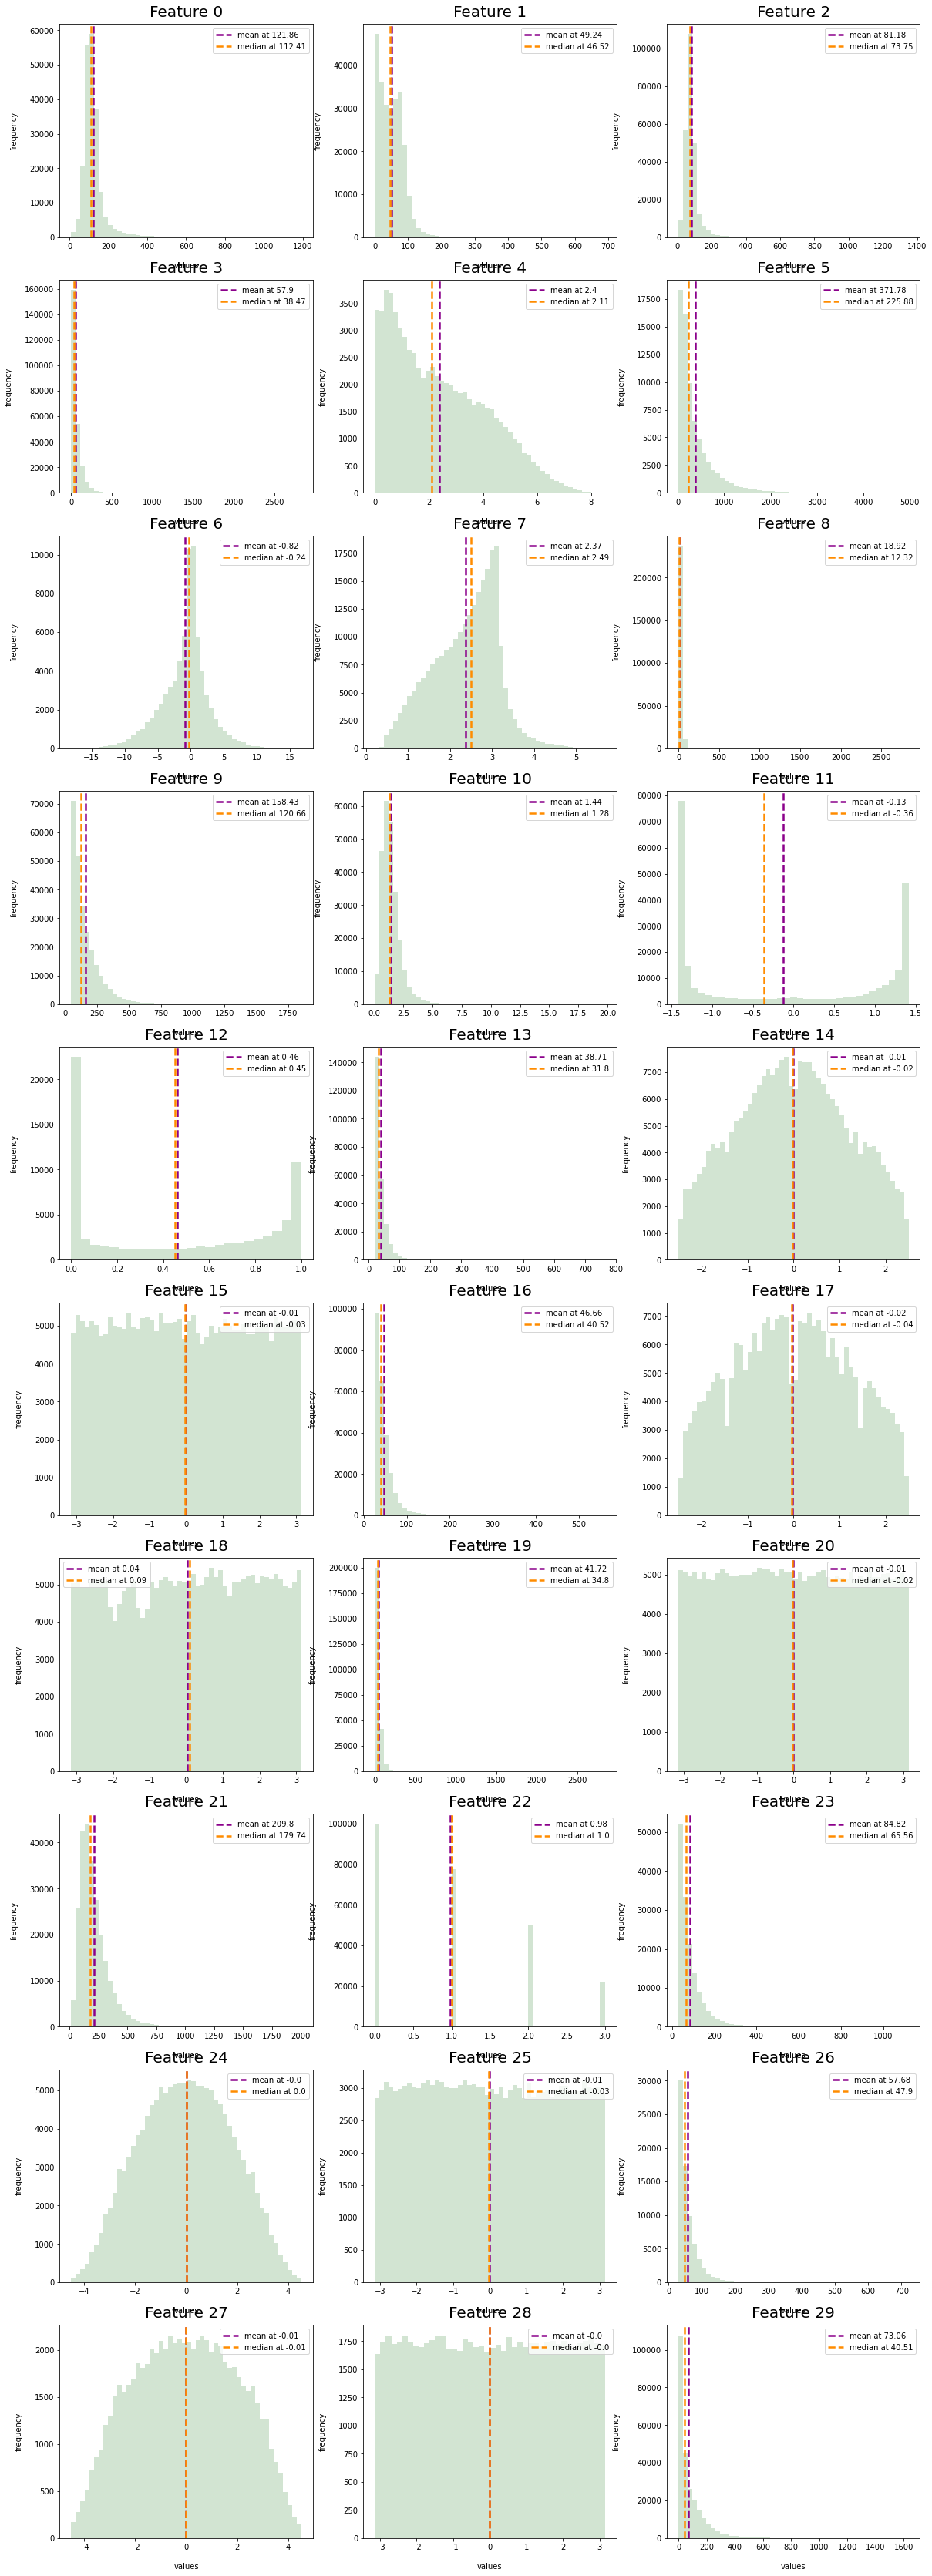

In [14]:
fig = plt.figure()
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    plt.xlabel("values", labelpad=15)
    plt.ylabel("frequency", labelpad=15)
    mean = round(np.nanmean(tX[:, i], axis=0), 2)
    median = round(np.nanmedian(tX[:, i], axis=0), 2)
    plt.title("Feature {}".format(i), fontsize=20, y=1.012)
    ax = sns.distplot(tX[:, i], kde=False, color='darkseagreen')
    plt.axvline(x=mean, linestyle='--', linewidth=2.5, label='{0} at {1}'.format("mean", mean), c='darkmagenta')
    plt.axvline(x=median, linestyle='--', linewidth=2.5, label='{0} at {1}'.format("median", median), c='darkorange')
    plt.legend()
fig.set_size_inches(20, 60)

These features are skewed:
0,1,2,3,4,5,7,8,9,10,11,12,13,16,19,21,23,26,29
Feature 22 is categorical

## Standardisation

Log-normalize the skewed indexes

In [15]:
log_norm_idx = [0,1,2,3,4,5,7,8,9,10,13,16,19,21,23,26,29]
for t_set in [tX, tX_test]:
    t_set[:, log_norm_idx] = np.log1p(t_set[:, log_norm_idx])

Standardisation

In [16]:
tX, mean_X_train, std_X_train = standardize(tX)
tX_test, mean_X_test, std_X_test = standardize(tX_test, mean_X_train, std_X_train)

Remove every NaN with the mean.
After standardisation the mean is 0. So NaN = 0.

In [17]:
for t_set in [tX, tX_test]:
    t_set[np.ma.masked_invalid(t_set).mask] = 0

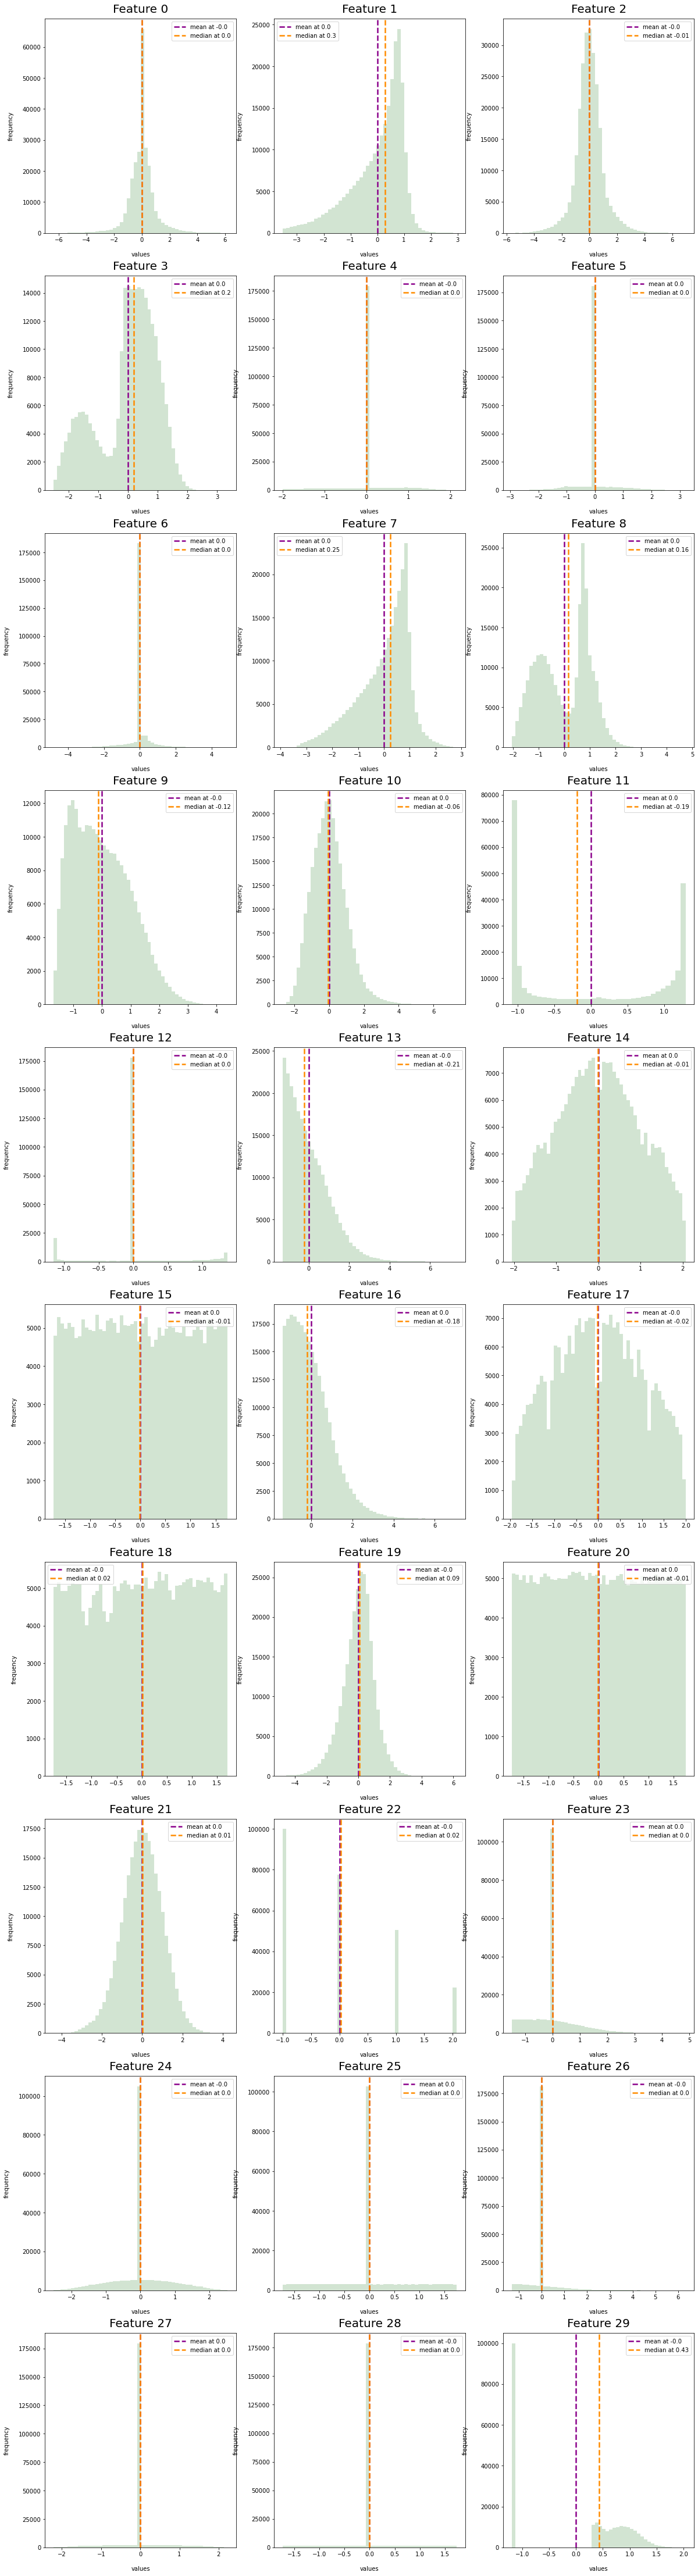

In [18]:
fig = plt.figure()
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    plt.xlabel("values", labelpad=15)
    plt.ylabel("frequency", labelpad=15)
    mean = round(np.nanmean(tX[:, i], axis=0), 2)
    median = round(np.nanmedian(tX[:, i], axis=0), 2)
    plt.title("Feature {}".format(i), fontsize=20, y=1.012)
    ax = sns.distplot(tX[:, i], kde=False, color='darkseagreen')
    plt.axvline(x=mean, linestyle='--', linewidth=2.5, label='{0} at {1}'.format("mean", mean), c='darkmagenta')
    plt.axvline(x=median, linestyle='--', linewidth=2.5, label='{0} at {1}'.format("median", median), c='darkorange')
    plt.legend()
fig.set_size_inches(20, 80)

The mean and the standard deviation is now 0 and 1 for every feature.

### Create Train, Validate and a Test Set

In [19]:
# from train take 20% as a validation set and 20% as a test set
tX_train, tX_val, y_train, y_val = split_data(tX, y, ratio=0.8, seed=1)
print("Size of the train set: {}. Size of the validation set: {}.".format(tX_train.shape[0], tX_val.shape[0]))

Size of the train set: 200000. Size of the validation set: 50000.


## First Taining: Getting a Baseline

### least_squares_GD and compute_loss_mse

[1. 0. 0. 0. 0. 1. 0. 0. 1. 0.] [[-0.30246921  0.05020628  0.09606354 -1.30266778  0.          0.
   0.          0.80976902 -0.65285674 -1.15163722 -0.52183724 -1.0754978
   0.         -0.17899078  1.64567349  0.63198851 -0.82507642  0.55456029
  -0.8964748  -1.15615458  1.46456862 -0.66693665 -1.00179211  0.
   0.          0.          0.          0.          0.         -1.1893372 ]
 [-1.00084958  0.19447166 -0.59859132 -0.23001654  0.          0.
   0.          0.40377073  0.59032787 -1.27260292 -0.82454406 -1.0696331
   0.         -0.14191973  0.34509617  1.08774506 -1.29472749  0.16245911
  -0.38177918  0.18580808 -1.14383566 -0.50198114 -1.00179211  0.
   0.          0.          0.          0.          0.         -1.1893372 ]
 [ 0.40859807  0.68157362  0.65067082  0.42566766  0.          0.
   0.          0.36349957 -0.82293795  0.36169437  1.3788506   1.21759893
   0.         -0.21183353  1.05180633  1.51708094  1.67107263  0.85654144
  -0.54857359 -0.76388803  1.72998907  0.53204

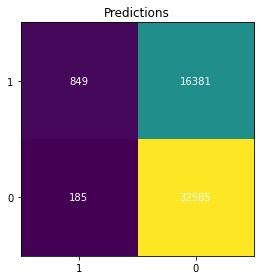

Recall: 0.04927452118398143
Precision: 0.8210831721470019
F_2 score: 0.06068273436829917
Accruacy: 0.66868
MSE loss 0.14426382245547476
Prediction example [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
# Training on the learning dataset
print(y_train[:10], tX_train[:3])
train_loss, weights = least_squares(y_train, tX_train)
print(train_loss)
print(weights)
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val) 
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

In step:   0%|                                                                                  | 0/10 [00:00<?, ?it/s]

In: Degree 0, Gamma 1e-06, Lambda None
In run: 0, trained. Train loss: 0.17133282579757272, Val loss: 0.17229881917725673.
In run: 1, trained. Train loss: 0.1713316516186293, Val loss: 0.17229763837806356.
In run: 2, trained. Train loss: 0.1713304774631692, Val loss: 0.17229645760241993.
In run: 3, trained. Train loss: 0.17132930333119198, Val loss: 0.17229527685032536.


In step: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 264.71it/s]


In run: 4, trained. Train loss: 0.17132812922269722, Val loss: 0.17229409612177937.
TP: 0, TN: 32770, FP: 0, FN: 17230


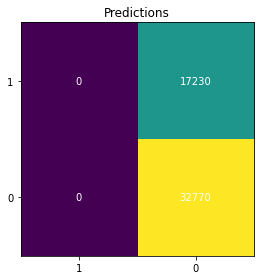

C:\Users\maxen\Desktop\EPFL\ml-project-1-mgo\project1\scripts\helpers_perso.py:234: RuntimeWarning: invalid value encountered in long_scalars
  print("Precision: {}".format(ppv))
In step: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 320.04it/s]

Recall: 0.0
Precision: nan
F_2 score: nan
Accruacy: 0.6554
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma 1e-06, Lambda None
In run: 0, trained. Train loss: 0.17132930332414728, Val loss: 0.17229527684324086.



In step: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 320.09it/s]


In run: 1, trained. Train loss: 0.17132460702401425, Val loss: 0.17229055406326071.
In run: 2, trained. Train loss: 0.17131991109957104, Val loss: 0.17228583166002948.
In run: 3, trained. Train loss: 0.17131521555078738, Val loss: 0.172281109633517.


In step: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 208.83it/s]


In run: 4, trained. Train loss: 0.17131052037763342, Val loss: 0.17227638798369324.
TP: 0, TN: 32770, FP: 0, FN: 17230


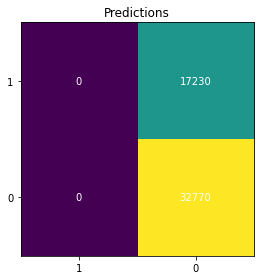

Recall: 0.0
Precision: nan
F_2 score: nan
Accruacy: 0.6554
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma 1e-06, Lambda None


In step:   0%|                                                                                  | 0/10 [00:00<?, ?it/s]

In run: 0, trained. Train loss: 0.171309346433521, Val loss: 0.17227520741939736.
In run: 1, trained. Train loss: 0.17128470321947442, Val loss: 0.17225042522041734.
In run: 2, trained. Train loss: 0.17126007035351318, Val loss: 0.17222565339870677.


In step: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 123.92it/s]


In run: 3, trained. Train loss: 0.17123544783129185, Val loss: 0.17220089194991414.
In run: 4, trained. Train loss: 0.171210835648467, Val loss: 0.17217614086968977.
TP: 0, TN: 32770, FP: 0, FN: 17230


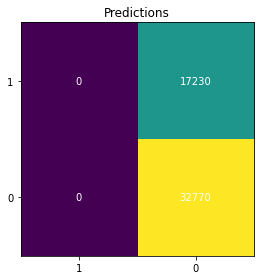

Recall: 0.0
Precision: nan
F_2 score: nan
Accruacy: 0.6554
----------------------------------------------------------------------------------------------------


In [24]:
val_iter, max_iter = 10, 50
degrees, gammas, lambdas_ = [0, 3, 5], [0.000001], [None]
method_train, method_loss = least_squares_GD, compute_loss_mse
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y, tX, max_iter, degrees, gammas, lambdas_)

### least_squares_SGD and compute_loss_mse

In: Degree 0, Gamma 1e-06, Lambda None
In run: 0, trained. Train loss: 0.1713336573342134, Val loss: 0.172299655402223.
In run: 1, trained. Train loss: 0.17133262934627994, Val loss: 0.17229862161833787.
In run: 2, trained. Train loss: 0.17133194403638477, Val loss: 0.1722979324445335.
In run: 3, trained. Train loss: 0.17133057342242614, Val loss: 0.1722965541027217.
In run: 4, trained. Train loss: 0.17132886018775623, Val loss: 0.17229483120829334.
TP: 0, TN: 32770, FP: 0, FN: 17230


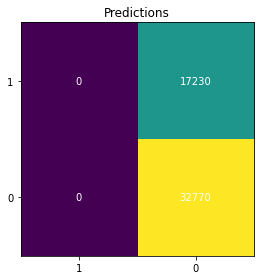

Recall: 0.0
Precision: nan
F_2 score: nan
Accruacy: 0.6554
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma 1e-06, Lambda None
In run: 0, trained. Train loss: 0.17132988818757802, Val loss: 0.17229586500431993.
In run: 1, trained. Train loss: 0.17132166506596744, Val loss: 0.17228759551659492.
In run: 2, trained. Train loss: 0.17131344283274955, Val loss: 0.17227932691902442.
In run: 3, trained. Train loss: 0.17130933248569669, Val loss: 0.17227519339291714.
In run: 4, trained. Train loss: 0.17130248185076305, Val loss: 0.17226830412410357.
TP: 0, TN: 32770, FP: 0, FN: 17230


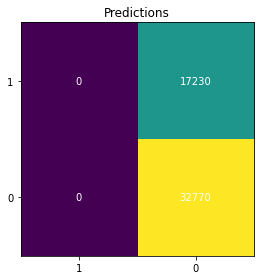

Recall: 0.0
Precision: nan
F_2 score: nan
Accruacy: 0.6554
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma 1e-06, Lambda None
In run: 0, trained. Train loss: 0.171298029753294, Val loss: 0.17226382691800096.
In run: 1, trained. Train loss: 0.17127646008399458, Val loss: 0.1722421355880725.
In run: 2, trained. Train loss: 0.17124051879141272, Val loss: 0.17220599152407537.
In run: 3, trained. Train loss: 0.17119740909053077, Val loss: 0.17216263852746796.
In run: 4, trained. Train loss: 0.17117587979556584, Val loss: 0.17214098769534514.
TP: 0, TN: 32770, FP: 0, FN: 17230


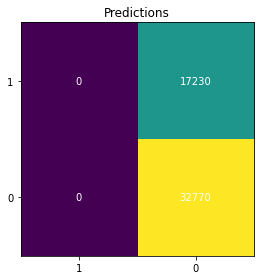

Recall: 0.0
Precision: nan
F_2 score: nan
Accruacy: 0.6554
----------------------------------------------------------------------------------------------------


In [25]:
val_iter, max_iter = 10, 50
degrees, gammas, lambdas_ = [0, 3, 5], [0.000001], [None]
method_train, method_loss = least_squares_SGD, compute_loss_mse
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y, tX, max_iter, degrees, gammas, lambdas_)

## Least Squares and compute_loss_mse

In: Degree 0, Gamma None, Lambda None
In run: 0, trained. Train loss: 0.112623320888, Val loss: 0.11292728631200001.
In run: 1, trained. Train loss: 0.112623320888, Val loss: 0.11292728631200001.
In run: 2, trained. Train loss: 0.112623320888, Val loss: 0.11292728631200001.
In run: 3, trained. Train loss: 0.112623320888, Val loss: 0.11292728631200001.
In run: 4, trained. Train loss: 0.112623320888, Val loss: 0.11292728631200001.
TP: 0, TN: 32770, FP: 0, FN: 17230


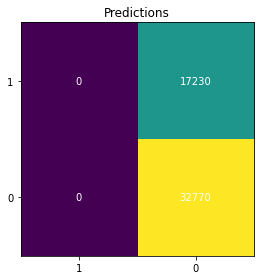

Recall: 0.0
Precision: nan
F_2 score: nan
Accruacy: 0.6554
----------------------------------------------------------------------------------------------------


In [26]:
degrees, gammas, lambdas_ = [0], [None], [None]
method_train, method_loss = least_squares, compute_loss_mse
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y, tX, max_iter, degrees, gammas, lambdas_)

## Second Training: PCA and Correlation

## Thrid Training: Splitting up by Feature 22

# OLD CODE

## Generate predictions and save ouput in csv format for submission:

## Steps:
1. Run and tune all methods on the full unchanged dataset and compare them
-- Use Grid Search for fitting ployn ...
2. Do feature selection, data cleaning, and so on - compare improvements
-- Do visualization

## Load the training data into feature matrix, class labels, and event ids:

### Load unchanged dataset

Standardize

Change labels which are -1 to 0

In [27]:
# Binary problem change the labels in y 
print("Example", y[0:10])
y = np.where(y == -1, 0, y)
print("Example after", y[0:10])

Example [1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
Example after [1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]


# Training with the unchanged dataset

### Create Train, Validate and a Test Set

In [28]:
# from train take 20% as a validation set and 10% as a test set
tX_train, tX_val, y_train, y_val = split_data(tX, y, ratio=0.8, seed=1)
print("Size of the train set: {}. Size of the validation set: {}.".format(tX_train.shape[0], tX_val.shape[0]))

Size of the train set: 200000. Size of the validation set: 50000.


### Training with least squares

### Training with least squares gradient descent

In step: 100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.21it/s]


TP: 828, TN: 32599, FP: 171, FN: 16402


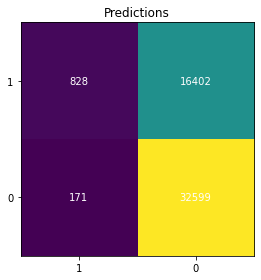

Recall: 0.048055716773070224
Precision: 0.8288288288288288
F_2 score: 0.05921137316037128
Accruacy: 0.66854
MSE loss 0.1442735652924395
Prediction example [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [29]:
# Training on the learning dataset

train_loss, weights = least_squares_GD(y_train, tX_train, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.1)
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val)
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

### Training with least squares stochastic gradient descent

TP: 7620, TN: 13542, FP: 19228, FN: 9610


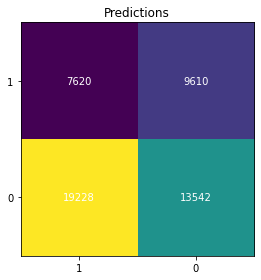

Recall: 0.4422518862449216
Precision: 0.2838200238379023
F_2 score: 0.39783643805864166
Accruacy: 0.42324
MSE loss 1.5809601797899625e+31
Prediction example [1. 1. 0. 1. 1. 0. 0. 0. 1. 1.]


In [30]:
# Training on the learning dataset

train_loss, weights = least_squares_SGD(y_train, tX_train, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.1)
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val) 
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

### Training with Newton method on logistic loss

TP: 10544, TN: 26795, FP: 5975, FN: 6686


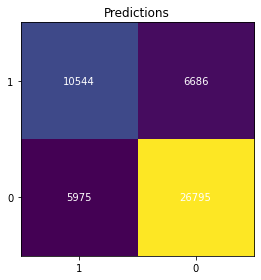

Recall: 0.6119558908879861
Precision: 0.6382952963254435
F_2 score: 0.6170484205105397
Accruacy: 0.74678
Logistic loss 28388.327977500005
Prediction example [0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]


In [31]:
# Training on the learning dataset

train_loss, weights = learning_by_newton_method(y_train, tX_train, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.5)
# Estimating the predictions on the validation set
pred_val = predict_labels(weights, tX_val)
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the logistic loss resulting from the validation set
loss_test = calculate_loss(y_val, tX_val, weights)
print("Logistic loss", loss_test)
print("Prediction example", pred_val[:10])

### Training with Gradient Descent on logistic loss

C:\Users\maxen\Desktop\EPFL\ml-project-1-mgo\project1\scripts\implementations.py:169: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
C:\Users\maxen\Desktop\EPFL\ml-project-1-mgo\project1\scripts\implementations.py:182: RuntimeWarning: divide by zero encountered in log
  return - (y.T).dot(np.log(pred)) - (1 - y).T.dot(np.log(1 - pred))


TP: 8778, TN: 15439, FP: 17331, FN: 8452


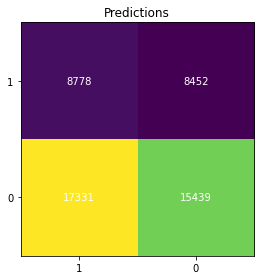

Recall: 0.5094602437608822
Precision: 0.336205906009422
F_2 score: 0.4618590114596597
Accruacy: 0.48434
Logistic loss nan
Prediction example [1. 0. 1. 0. 1. 0. 1. 0. 1. 1.]


In [32]:
# Training on the learning dataset

train_loss, weights = logistic_regression(y_train, tX_train, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.1)
# Estimating the predictions on the validation set
pred_val = predict_labels(weights, tX_val)
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the logistic loss resulting from the validation set
loss_test = calculate_loss(y_val, tX_val, weights)
print("Logistic loss", loss_test)
print("Prediction example", pred_val[:10])

### Training with regularized logistic regression

TP: 12375, TN: 20940, FP: 11830, FN: 4855


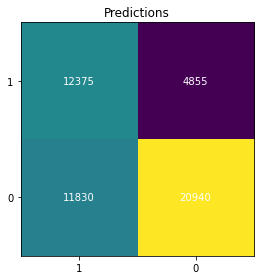

Recall: 0.7182240278583866
Precision: 0.5112580045445156
F_2 score: 0.6644295302013423
Accruacy: 0.6663
Logistic loss nan
Prediction example [1. 1. 0. 0. 0. 1. 1. 0. 1. 0.]


In [33]:
# Training on the learning dataset

train_loss, weights = reg_logistic_regression(y_train, tX_train, lambda_=0.5, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.1)
# Estimating the predictions on the validation set
pred_val = predict_labels(weights, tX_val)
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the logistic loss resulting from the validation set
loss_test = calculate_loss(y_val, tX_val, weights)
print("Logistic loss", loss_test)
print("Prediction example", pred_val[:10])

### Exploring the data

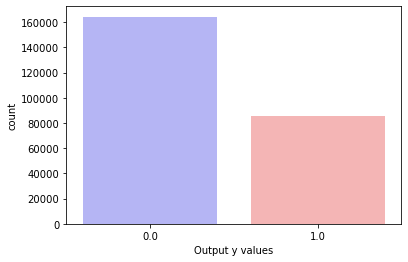

In [34]:
#Exploring y
sns.countplot(x = y, palette = "bwr") 
plt.xlabel("Output y values")
plt.show()

We can remark that the data are not well balanced for the output and this can cause some trouble.

30


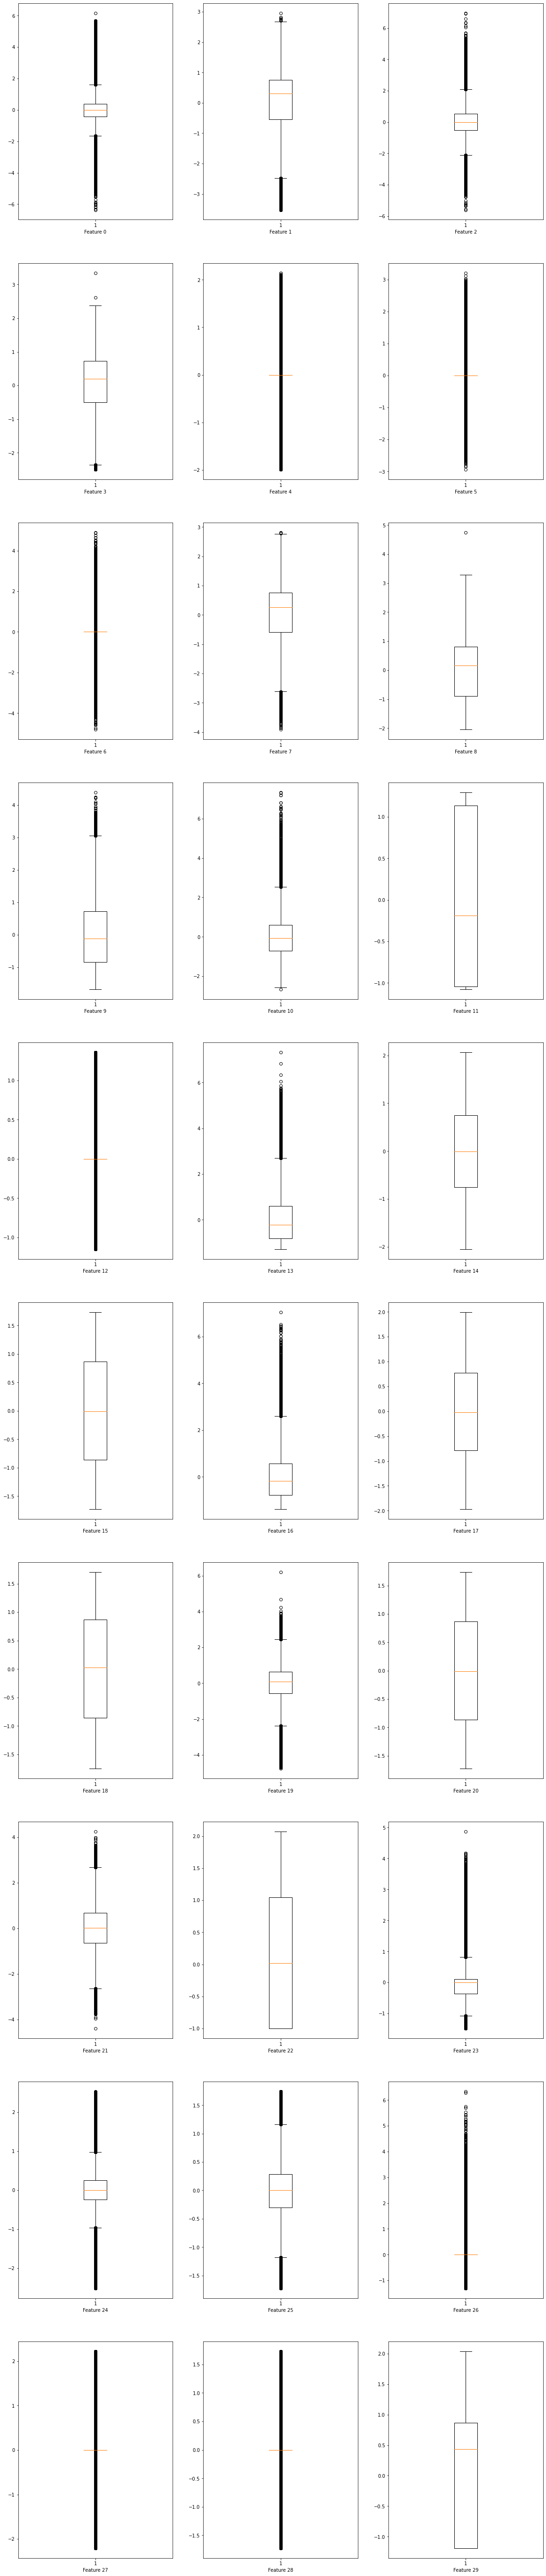

In [35]:
fig = plt.figure()
print(tX.shape[1])
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    #remove useless values
    tX_tmp = tX[:, i]
    tX_tmp = tX_tmp[tX_tmp > -999]
    plt.boxplot(tX_tmp)
    plt.xlabel("Feature " + str(i))
fig.set_size_inches(20, 100)

30


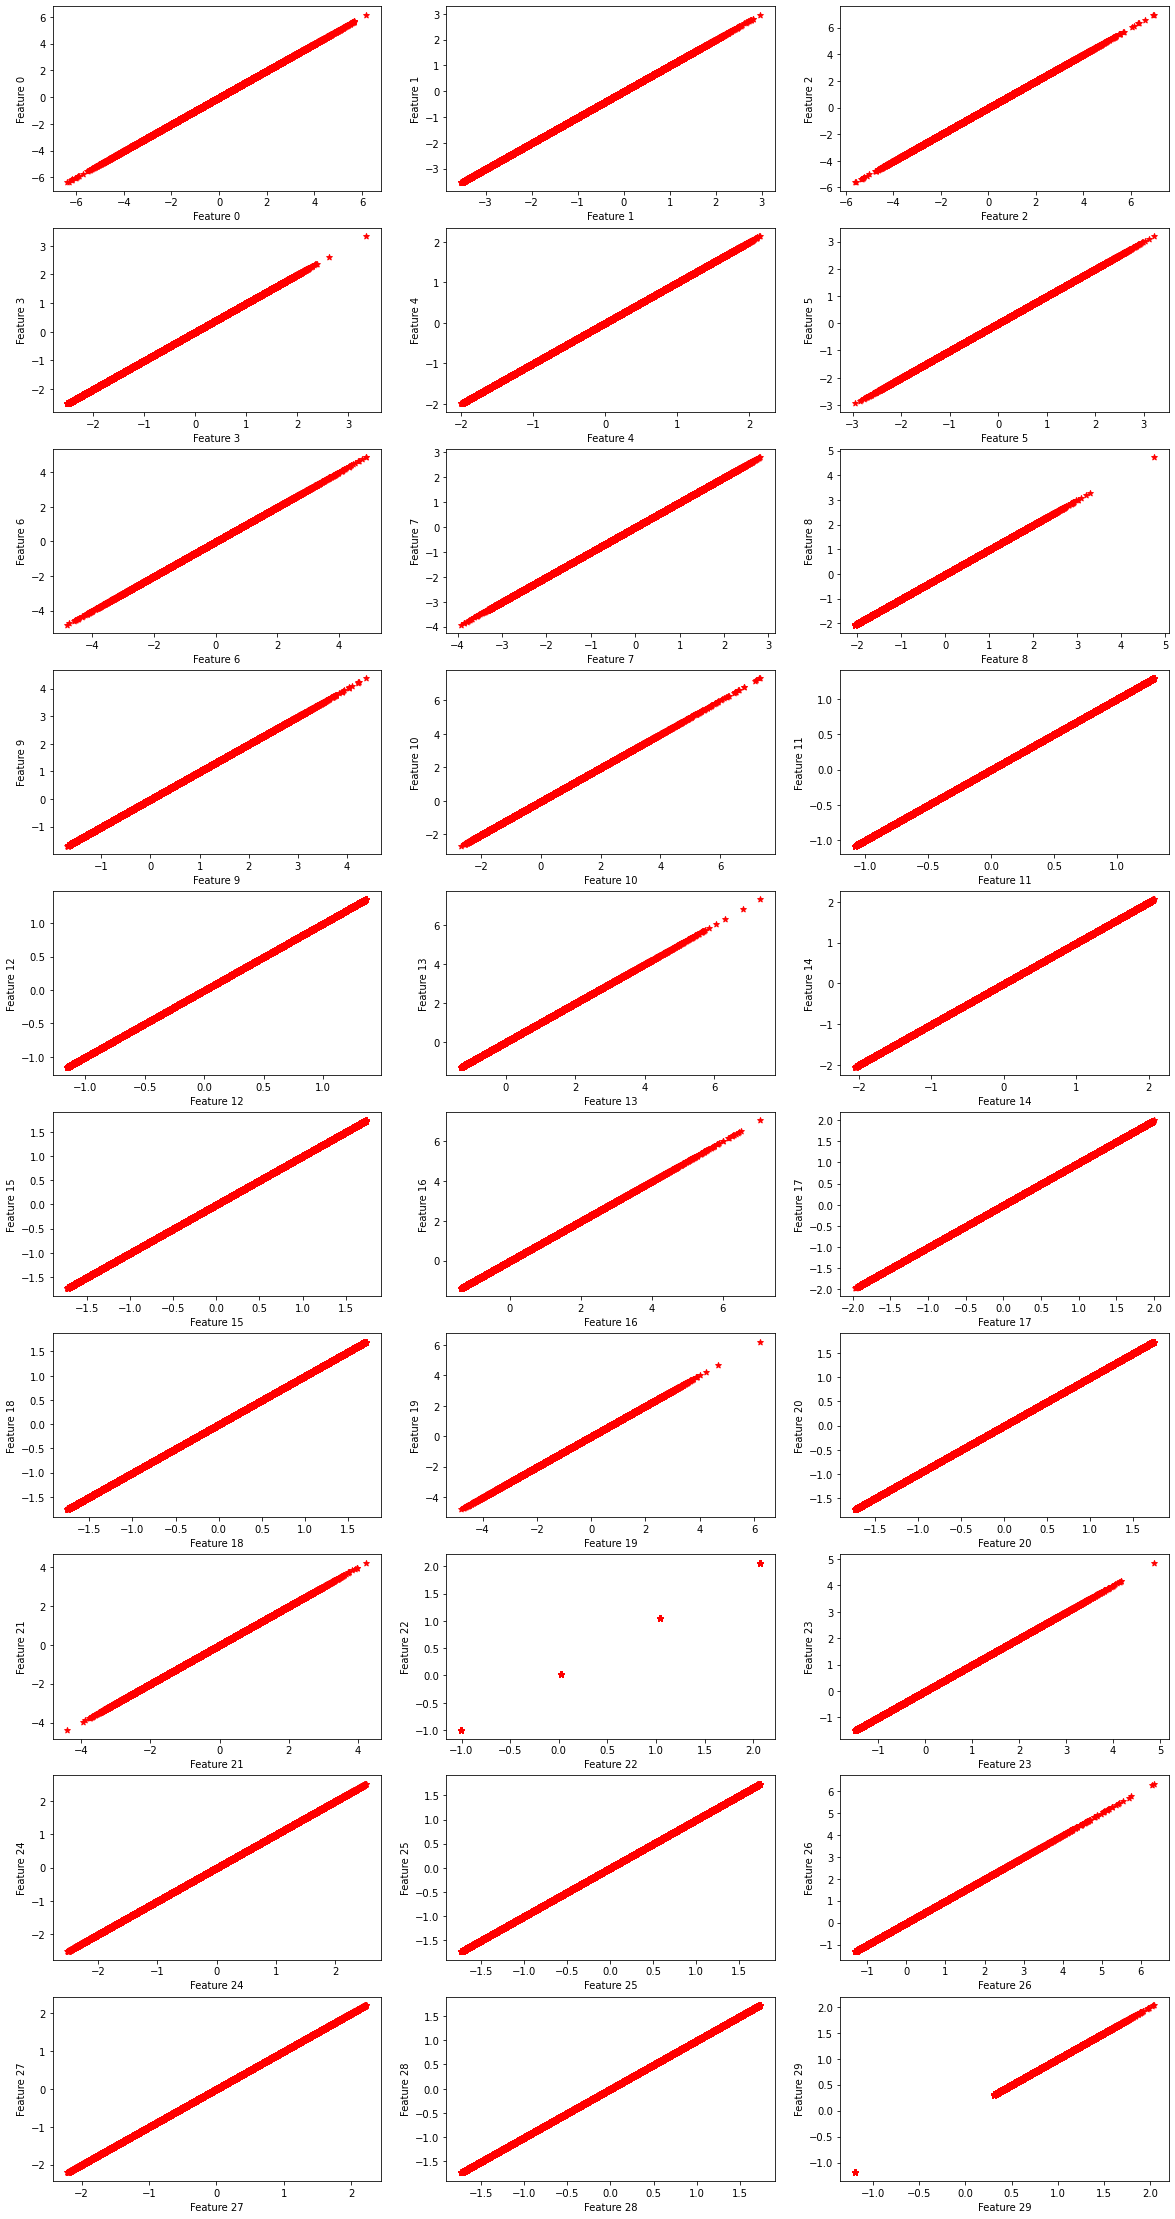

In [36]:
fig = plt.figure()
print(tX.shape[1])
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    #remove useless values
    tX_tmp = tX[:, i]
    tX_tmp = tX_tmp[tX_tmp > -999]
    ax.scatter(tX_tmp, tX_tmp, marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(i))
fig.set_size_inches(20, 40)

### Interpretation

Thoses graphs shows the distribution of the features. 
We can see directly that a feature is categorical :
- Feature with 4 categories : 22

For the other features, we can see that only a few of them seems well distributed whereas the other have some outliers :
- Features with Outliers : 0, 1, 2, 3, 5, 8, 9, 10, 13, 16, 19, 21, 26, 29



# Feature processing 

Feature processing : Cleaning the dataset by removing useless features and values, combining others, finding better representations of the features to feed your model, scaling the features, and so on. Check this article
on feature engineering: 

http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

## Removing useless features

In [37]:
tX
tX.shape

(250000, 30)

In [38]:
# Removing useless features

# We begin by removing all the line with a PRI_jet_all_pt equal to 0
#print(tX.shape, y.shape, ids.shape)
#line_array = np.int_([])
#for i in range (tX.shape[0]):
#    if tX[i, 29] == 0. :
#        line_array = np.append(line_array, i)
#tX = np.delete(tX, line_array, axis=0)
#y = np.delete(y, line_array, axis=0)
#ids = np.delete(ids, line_array, axis=0) 
#tX = tX[np.where(tX[:, 29] != 0.)]
#print(tX[:15,:])
#tX.shape, y.shape, ids.shape

In [39]:
#Useless feature with

In [40]:
# Removing rows with missing values (Nan)

#tX = tX[~np.isnan(tX).any(axis=1)]
#print(tX[:15,:])
#tX.shape

In [41]:
#Correlation between features
linear_relation = []
mat = np.corrcoef(tX, rowvar = 0)
#print(mat)
for i in range(mat.shape[0]):
    for j in range(0, i):
        if mat[i, j] > 0.999:
            linear_relation.append((j, i, mat[i, j]))
linear_relation

[]

In [42]:
from math import *
#Visualization for the linear relation between feature
fig = plt.figure()
k = 1
for (i, j, r) in linear_relation : 
    ax = fig.add_subplot((len(linear_relation)//3)+1, 3, k)
    #we keep useless values to see the relation between features when one is -999
    ax.scatter(tX[:,i], tX[:,j], marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(j))
    k += 1
fig.set_size_inches(20, 40)

<Figure size 1440x2880 with 0 Axes>

In [43]:
#As they are corrolated, we can remove one of the features in the final input 
column_array = np.int_([])
for (i, j, r) in linear_relation :
    if not (i in column_array) :
        column_array = np.append(column_array, i)
    else :
        if not (j in column_array) :
            column_array = np.append(column_array, j)
tX = np.delete(tX, column_array, axis=1)
tX.shape

(250000, 30)

We will now work only with 22 features

### Corrolation with prediction :

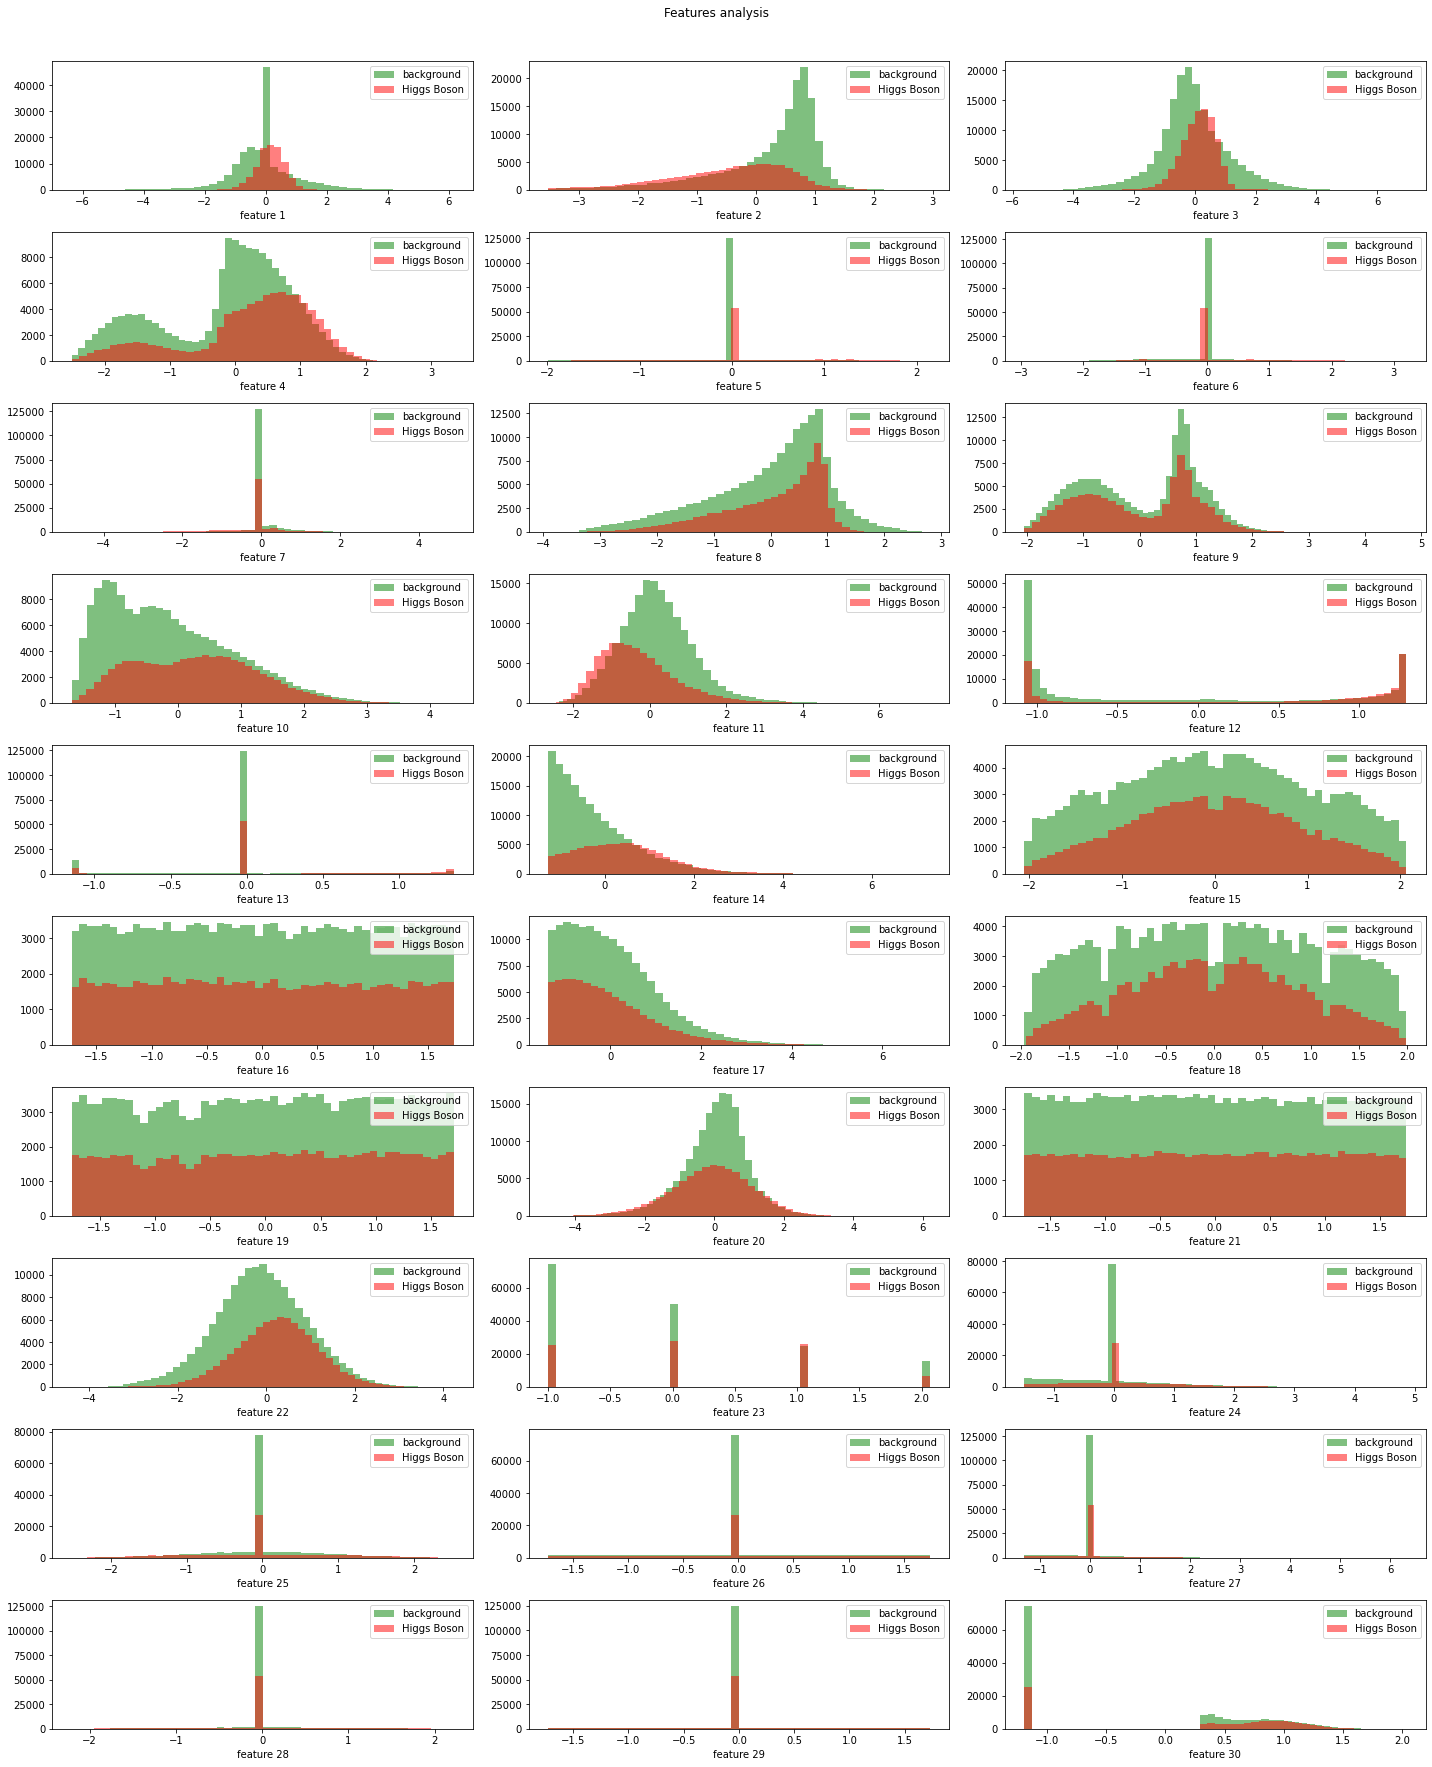

In [46]:
fig = plt.figure(figsize = (20, 25))
j = 0

#Constructing a new matrice for esier plot
y_reshaped = y.reshape(y.shape[0], 1)
mat = np.concatenate((y_reshaped, tX), axis=1)

#print (mat)
#print(mat_one)
    
#print(np.where(mat[:, 0] == -1.))
#print(mat[np.where(mat[:, 0] == -1.), 2])
for i in range(1, mat.shape[1]):
    plt.subplot(10, 3, j+1)
    j += 1
    mat_minus_one = mat[np.where(mat[:, 0] == 0.), i].flatten()
    mat_one = mat[np.where(mat[:, 0] == 1.), i].flatten()
    plt.hist(mat_minus_one[np.where(mat_minus_one != -999.)], bins= 50, color='g', label = 'background', alpha=0.5)
    plt.hist(mat_one[np.where(mat_one != -999.)], bins=50, color='r', label = 'Higgs Boson', alpha=0.5)
    plt.xlabel("feature "+ str(j))
    plt.legend(loc='best')
fig.suptitle('Features analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Let's use from the features we have the most interesting ones : 

- 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 19, 20, 21, 22, 23

We remove:

- 13, 16, 18, 22

In [47]:
column_array = [13, 16, 18, 22]

if tX.shape[1]==23 :
    tX = np.delete(tX, column_array, axis=1)

tX.shape

(250000, 30)

In [48]:
#replace useless values with the mean of the usefull features
number_features = tX.shape[1]
for i in range(0, number_features):
    tX_tmp = tX[:, i]
    indices = np.where(tX_tmp == -999)
    tX_tmp = tX_tmp[tX_tmp > -999] 
    np.put(tX[:, i], indices, tX_tmp.mean())

In [49]:
tX, mean_tX, std_tX = standardize(tX)

In [50]:
#Corrolation of features with the prediction
tX_y_relation = []
mat = np.corrcoef(tX, y, rowvar = 0)
print(mat)
for i in range(mat.shape[0]):
    for j in range(0, i):
        if mat[i, j] > 0.999:
            tX_y_relation.append((j, i, mat[i, j]))
print(tX_y_relation)
for (i, j, r) in tX_y_relation : 
    ax = fig.add_subplot((len(tX_y_relation)//3)+1, 3, k)
    #we keep useless values to see the relation between features when one is -999
    ax.scatter(tX[:,i], tX[:,j], marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(j))
    k += 1
fig.set_size_inches(20, 40)

[[ 1.00000000e+00  4.81699368e-02  7.50137854e-01  8.37932981e-03
   1.01117992e-02  7.12122282e-03 -1.63902429e-02  4.75786757e-01
  -1.33074230e-02  1.66419961e-01  1.05820588e-03  5.26682364e-02
   1.03227377e-02  3.01052980e-01  2.40366854e-03 -3.59889879e-03
   3.14585566e-01  2.33201691e-03 -2.10074495e-03  8.94104769e-02
   1.56134170e-03  8.74025579e-02  9.83055527e-03  2.23098293e-02
   1.82293747e-03  7.16993822e-03 -8.98711423e-03  1.77425345e-03
  -2.63688889e-03  1.25362214e-02  1.26705607e-01]
 [ 4.81699368e-02  1.00000000e+00  7.74756749e-02 -2.73196882e-01
  -6.57079916e-02 -8.11914552e-02  6.83641090e-02  4.85485482e-02
  -2.46939844e-02 -2.24600107e-01  2.97309370e-01 -4.34717161e-01
  -6.05270340e-02 -2.05240134e-01 -3.00478727e-03  2.64337811e-05
   2.12994260e-01 -8.40769518e-03 -2.91733033e-04  1.81677690e-01
  -1.63418230e-02 -2.23663869e-01 -2.33135666e-01 -1.48281133e-01
   1.97451334e-04  4.51517776e-03 -3.00419288e-02 -1.42569436e-04
   4.66455393e-03 -2.6753

### Trainer

In [51]:
# testing trainer with validation
loss, weights = trainer_val(y_val, tX_val, 10, least_squares_GD, compute_loss_mse, y_train, tX_train, [0] * tX_train.shape[1], 55, 0.0001)

IndexError: tuple index out of range

TP: 12375, TN: 20940, FP: 11830, FN: 4855


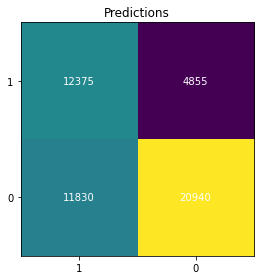

Recall: 0.7182240278583866
Precision: 0.5112580045445156
F_2 score: 0.6644295302013423
Accruacy: 0.6663
MSE loss 78887372.64052963
Prediction example [1. 1. 0. 0. 0. 1. 1. 0. 1. 0.]


In [52]:
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val) #### using -1!!!
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

# Training with the filtered dataset

In [56]:
OUTPUT_PATH = '../data/output.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)

#change 0 into -1
print("Example", y_pred[0:10])
y_pred = np.where(y_pred == 0., -1., y_pred)
print("Example after", y_pred[0:10])
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

Example [0. 0. 1. 1. 0. 0. 1. 0. 0. 1.]
Example after [-1. -1.  1.  1. -1. -1.  1. -1. -1.  1.]
